In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from pathlib import Path

# Small style adjustments for more readable plots
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 14

In [14]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec

import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

In [15]:
# load the dataset
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")

In [16]:
R_earth = 6371 # radius of Earth in km

def offshore_lon(lat, lon, distance):
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    
    # Calculate the distance in longitude degrees based on the given distance in km
    d_lon = np.degrees(distance / (R_earth * np.cos(lat_rad) * 2 * np.pi / 360))

    # Calculate the offshore longitude
    offshore_lon = lon + d_lon

    return offshore_lon

In [17]:
monterey = ds.analysed_sst.sel(lat = 36, lon = offshore_lon(36, -139, 1), method = 'nearest') - 273.15
monterey = monterey.rolling(time = 31, center = True, min_periods = 1).mean()

In [18]:
# daily SSTs during 2002-2013
data_2002_2013 = monterey.sel(time = slice('2002', '2013')).groupby('time.dayofyear')

# max and min values during 2002-2013
maximum = data_2002_2013.max()
minimum = data_2002_2013.min()

# mean and sd values during 2002-2013
mean = data_2002_2013.mean()
std = data_2002_2013.std()

# ±1 sd around the mean during 2002-2013
upper = mean + std
lower = mean - std

In [19]:
SST_2014 = monterey.sel(time = '2014').groupby("time.dayofyear").mean()
SST_2015 = monterey.sel(time = '2015').groupby("time.dayofyear").mean()
SST_2016 = monterey.sel(time = '2016').groupby("time.dayofyear").mean()

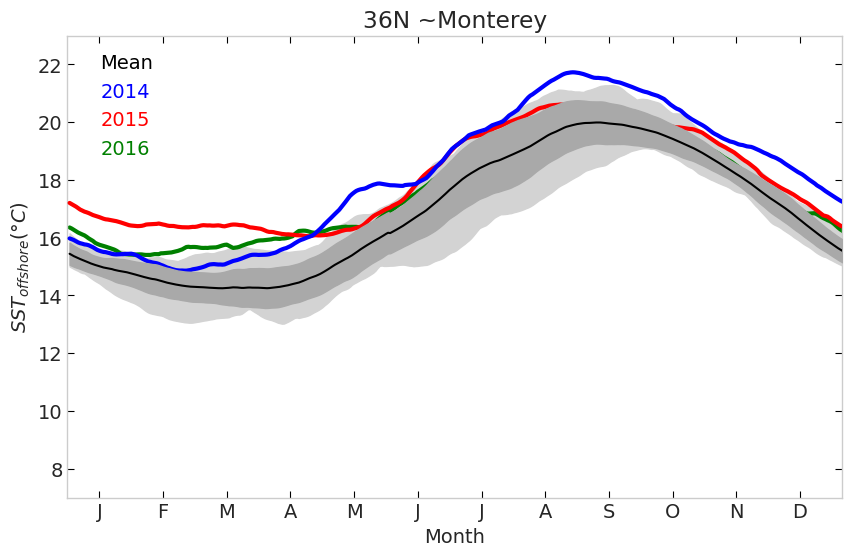

In [20]:
# create figure and axis objects
figure, axis = plt.subplots(figsize=(10, 6))

# plot mean data from 2002-2013
plt.plot(mean.dayofyear.values, mean, 'k', label = 'Mean', zorder = 6)

# plot shaded areas for maximum and minimum 
plt.fill_between(mean.dayofyear.values, minimum, maximum, color = 'lightgray', zorder = 1)

# plot shaded area between lower and upper bound
plt.fill_between(mean.dayofyear.values, lower, upper, color = 'darkgray', zorder = 5)

# plot smoothed time series for 2014, 2015, and 2016
plt.plot(SST_2014.dayofyear.values, SST_2014, color = 'blue', label = '2014', linewidth = 3, zorder = 4)
plt.plot(SST_2015.dayofyear.values, SST_2015, color = 'red', label = '2015', linewidth = 3, zorder = 3)
plt.plot(SST_2016.dayofyear.values, SST_2016, color = 'green', label = '2016', linewidth = 3, zorder = 2)

# labeling x-axis with months
axis.set_xticks(np.arange(15, 360, 30))
axis.set_xticklabels(['J', 'F', 'M','A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
axis.tick_params(color = 'black', direction = 'in', length = 5, top = True, right = True)
axis.legend(labelcolor = 'linecolor', loc = 'upper left', handlelength = 0)
axis.grid(False)

plt.ylim(7, 23)
plt.xlim(0, 365)
plt.ylabel('$SST_{offshore}(°C)$')
plt.xlabel('Month')
plt.title('36N ~Monterey')
plt.show()

In [21]:
figure.savefig('outputs/Q6_image')